In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import sunpy.coordinates

from scipy.interpolate import griddata
from fluxpipe.helpers.pipe_helper import (sunspotplot, parse_big_dict, load_wind_files)
%matplotlib widget
VMIN = 450
VMAX = 700

/opt/homebrew/anaconda3/envs/fluxenv/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 2532 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/opt/homebrew/anaconda3/envs/fluxenv/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 2532 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/opt/homebrew/anaconda3/envs/fluxenv/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 2532 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/opt/homebrew/anaconda3/envs/fluxenv/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "epv00" yielded 1812 of "warning: date outsidethe range 1900-2100 AD"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


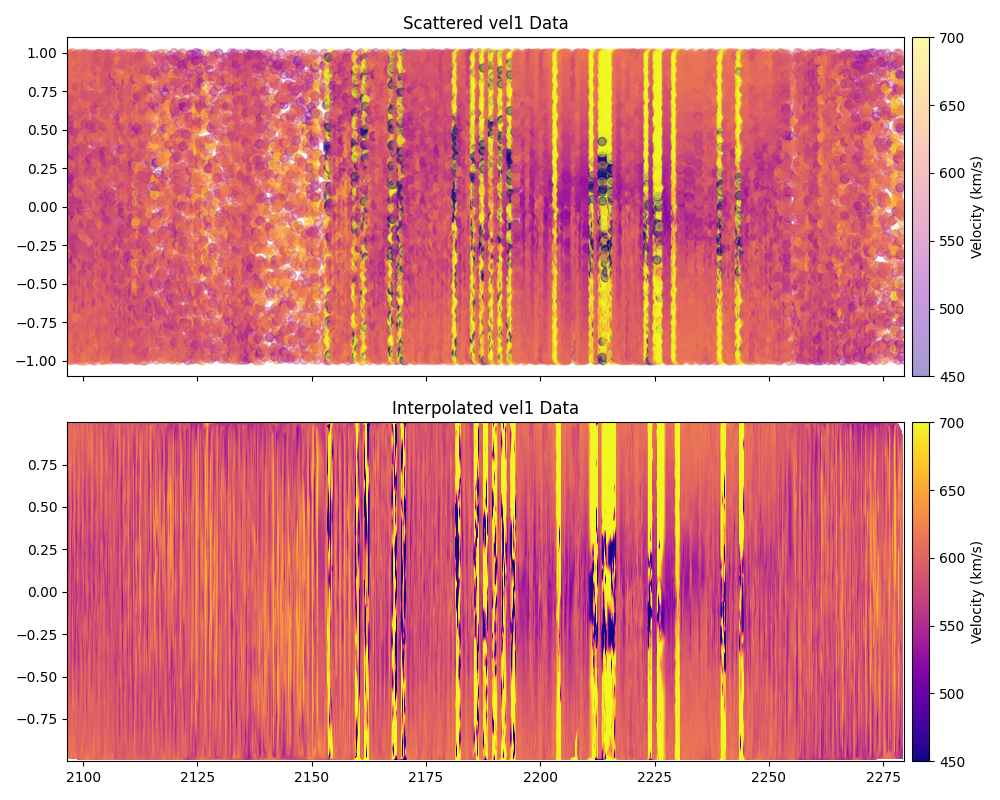

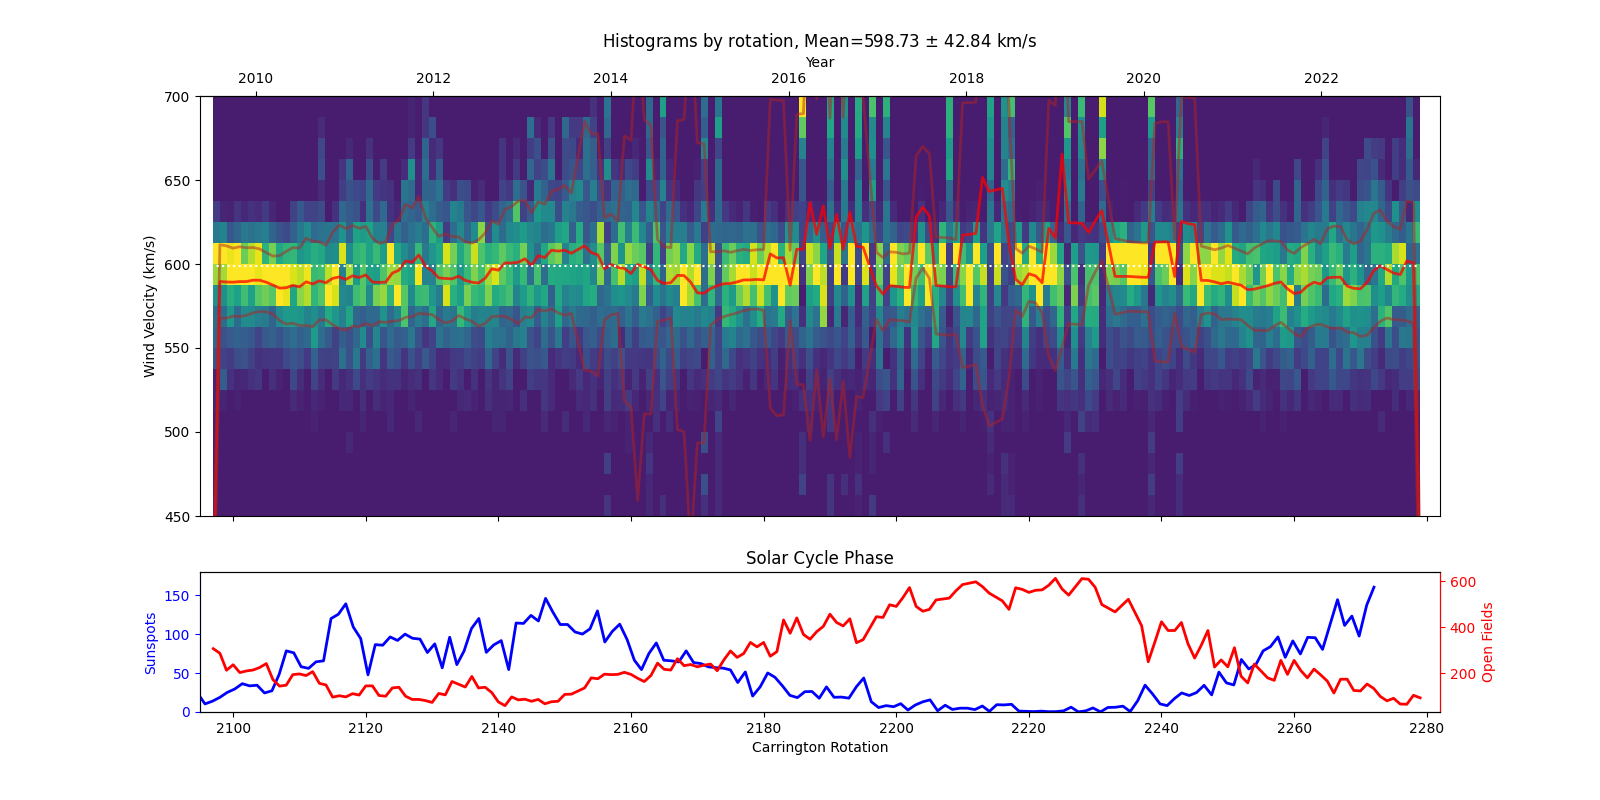

In [2]:
def scatter_all_keys(big_dict, **kwargs):

    for key in big_dict[2160].keys():
        scatter_all(big_dict, field=key, **kwargs)

def scatter_all(big_dict, field="vel1", **kwargs):
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    vmin = kwargs.get("vmin", VMIN)
    vmax = kwargs.get("vmax", VMAX)
    # Create figure

    if False:
        fig = plt.figure(figsize=(10, 8))
        # Define GridSpec: 4 rows, 1 column. Adjust the height ratios as needed.
        gs = gridspec.GridSpec(4, 1, height_ratios=[3, 3, 6, 8])

        # Create each subplot
        ax1 = fig.add_subplot(gs[2, 0])  # First row
        ax2 = fig.add_subplot(gs[0, 0], sharex=ax1)  # Second row
        ax3 = fig.add_subplot(gs[1, 0], sharex=ax2, sharey=ax2)  # Third row
        ax4 = fig.add_subplot(gs[3, 0], sharex=ax2)  # fourth row
    else:
        fig1, (ax4, ax1) = plt.subplots(2, 1, sharex=True, gridspec_kw={"height_ratios":[3,1]})
        fig2, (ax2, ax3) = plt.subplots(2, 1, sharex=True)



    axarray = [ax1, ax2, ax3, ax4]

    axarray[0].set_ylim(0,180)
    axarray[0].set_ylabel("Sunspots", color='b')
    axarray[0].tick_params(axis='y', colors='b')
    axarray[0].spines['left'].set_color('b')
    axarray[0].set_title("Count of Sunspots and Open Fields")

    carr_ax2 = axarray[0].twinx()
    carr_ax2.set_ylabel("Open Fields", color='r')
    carr_ax2.tick_params(axis='y', colors='r')
    carr_ax2.spines['right'].set_color('r')
    # carr_ax2.set_ylim(50, 800)



    sunspotplot(axarray[0])

    all_phi, all_theta, all_vel, all_hist, all_cr, all_mean, \
    all_std, total_mean, total_std, all_count = parse_big_dict(big_dict)

    carr_ax2.plot(all_cr, all_count, c='r', lw=2)


    all_hists = all_hist.T
    cmean = np.mean(all_hists)
    cstd = np.std(all_hists)
    cmin = cmean - cstd
    cmax = cmean + 3*cstd

    axarray[3].imshow(all_hists, aspect='auto',
                      extent=(all_cr[0], all_cr[-1], vmin, vmax),
                      vmin=cmin, vmax=cmax,
                      cmap='viridis', origin='lower')


        # Function to convert Carrington Rotation numbers to years
    def cr_to_years(cr):
        start_year = 1853
        cr_start = 1
        days_per_cr = 27.2753
        days_since_start = (cr - cr_start) * days_per_cr
        years_since_start = days_since_start / 365.25
        return start_year + years_since_start

    # Inverse function to convert years back to Carrington Rotation numbers
    def years_to_cr(years):
        start_year = 1853
        cr_start = 1
        days_per_year = 365.25
        days_per_cr = 27.2753
        years_since_start = years - start_year
        days_since_start = years_since_start * days_per_year
        return (days_since_start / days_per_cr) + cr_start

    secax = axarray[3].secondary_xaxis('top', functions=(cr_to_years, years_to_cr))
    secax.set_xlabel('Year')


    smoothed_mean = np.convolve(all_mean, np.ones(3)/3, mode='same')
    smoothed_std = np.convolve(all_std, np.ones(3)/3, mode='same')

    # histavg = np.average(all_vel, axis=0)
    # axarray[3].plot(all_cr, all_mean, c='firebrick', lw=2, alpha=0.75)
    axarray[3].plot(all_cr, smoothed_mean, c='r', lw=2, alpha=0.75)
    axarray[3].plot(all_cr, smoothed_mean+smoothed_std, c='firebrick', lw=2, alpha=0.5)
    axarray[3].plot(all_cr, smoothed_mean-smoothed_std, c='firebrick', lw=2, alpha=0.5)
    axarray[3].axhline(total_mean, c='w', ls=":")
    # axarray[3].axhline(total_mean+total_std, c='k', ls=":")
    # axarray[3].axhline(total_mean-total_std, c='k', ls=":")


    # axarray[0].set_yscale('log')s

    # Scatter plot for each CR
    scatt = axarray[1].scatter(all_phi, all_theta, c=all_vel, **kwargs)

    plt.colorbar(scatt, ax=axarray[1], orientation='vertical', fraction=0.03, pad=0.01, label='Velocity (km/s)')


    # Create a regular grid where you want to interpolate data
    grid_phi, grid_theta = np.mgrid[min(all_phi):max(all_phi):1000j, min(all_theta):max(all_theta):1000j]

    # Interpolate scattered data to the regular grid
    grid_vel = griddata((all_phi, all_theta), all_vel, (grid_phi, grid_theta), method='linear')

    # Display the interpolated data as an image
    im = axarray[2].imshow(grid_vel.T, cmap="plasma", extent=(min(all_phi), max(all_phi), min(all_theta), max(all_theta)),
                      origin='lower', aspect='auto', vmin=vmin, vmax=vmax)
    plt.colorbar(im, ax=axarray[2], orientation='vertical', fraction=0.03, pad=0.01, label='Velocity (km/s)')



    axarray[3].set_title(f'Histograms by rotation, Mean={total_mean:0.2f} $\pm$ {total_std:0.2f} km/s')
    axarray[2].set_title(f'Interpolated {field} Data')
    axarray[1].set_title(f'Scattered {field} Data')
    axarray[0].set_xlabel('Carrington Rotation')
    axarray[3].set_ylabel('Wind Velocity (km/s)')

    axarray[3].set_ylim((450, 700))

    fig1.set_size_inches(16, 8)
    fig2.set_size_inches(10, 8)

    plt.tight_layout()
    plt.tight_layout()
    plt.tight_layout()
    # plt.subplots_adjust(hspace=0.5,
    #                     wspace=0.75)

    plt.show()


# Example usage
directory_path = '/Users/cgilbert/vscode/fluxons/fluxon-data/batches/sequential_bkk/data/wind'  # Change this to your directory's path
big_dict = load_wind_files(directory_path)
all_phi, all_theta, all_vel, all_hist, all_cr, all_mean, \
all_std, total_mean, total_std, all_count = parse_big_dict(big_dict)

scatter_all(big_dict, cmap='plasma', alpha = 0.4, vmin=450, vmax=700)

In [3]:
# def scatter_all(big_dict, field="vel1", ax=None, **kwargs):
#     if ax is None:
#         fig, ax = plt.subplots(figsize=(15, 6))  # Fallback if no ax is provided

#     # Plot data for each CR with an offset
#     for ii, CR in enumerate(sorted(big_dict.keys())):
#         phi_data = big_dict[CR]['ph1'] + (ii * 2 * np.pi)  # Offset for clarity
#         theta_data = big_dict[CR]['th1']
#         field_data = big_dict[CR][field]

#         ax.scatter(phi_data, theta_data, c=field_data, alpha=0.5, **kwargs)

#     ax.set_title(f'Scattered {field} Data Across CRs')
#     ax.set_xlim((0, 2 * np.pi * len(big_dict.keys())))

# def scatter_all_keys(big_dict, **kwargs):
#     # Determine the number of fields for subplot dimensions
#     first_CR = next(iter(big_dict))
#     fields = [key for key in big_dict[first_CR].keys()]
#     n_fields = len(fields)

#     # Create a figure with a subplot for each field
#     fig, axs = plt.subplots(n_fields, 1, figsize=(15, 6 * n_fields), sharex=True, sharey=True)

#     if n_fields == 1:  # If there's only one field, axs is not a list but a single AxesSubplot object
#         axs = [axs]

#     # Iterate over fields and plot
#     for ax, field in zip(axs, fields):
#         scatter_all(big_dict, field=field, ax=ax, **kwargs)

#     plt.tight_layout()
#     plt.show()


In [4]:



import cv2
import os
from tqdm import tqdm

def images_to_video(input_dir, output_file, fps):
    # Get all PNG files in the input directory
    image_files = [f for f in os.listdir(input_dir) if f.endswith('.png')]
    image_files.sort()  # Ensure the files are in sorted order

    # Check if there are any PNG files in the directory
    if len(image_files) == 0:
        print("No PNG files found in the directory.")
        return

    # Determine the size of the first image
    sample_image = cv2.imread(os.path.join(input_dir, image_files[0]))
    height, width, _ = sample_image.shape

    # Initialize video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_file, fourcc, fps, (width, height))

    # Iterate through each image and write it to the video
    for image_file in tqdm(image_files):
        image_path = os.path.join(input_dir, image_file)
        frame = cv2.imread(image_path)
        out.write(frame)

    # Release resources
    out.release()

    print(f"Video created successfully: {output_file}")

wind_path = '/Users/cgilbert/vscode/fluxons/fluxon-data/batches/sequential/imgs/windmap'  # Change this to your directory's path

images_to_video(wind_path, os.path.join(wind_path,"wind_video.mp4"), 10)


100%|██████████| 6/6 [00:00<00:00, 17.39it/s]

Video created successfully: /Users/cgilbert/vscode/fluxons/fluxon-data/batches/sequential/imgs/windmap/wind_video.mp4
